In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd

data_folder = "query_data/"

paths = [
    data_folder + "training.jsonl",
    data_folder + "TAR_data.jsonl",
    data_folder + "sysrev_conv.jsonl",
]
dataset = []
for path in paths:
    df = pd.read_json(path, lines=True)
    dataset.append(df)

dataset = pd.concat(dataset)
# dataset = dataset[dataset["nl_query"] != ""]
dataset

,nl_query,bool_query,source,quality,mission_hash,pmid,id,link_to_review,search_name,Date_from,Date_to,seed_studies,included_studies,edited_search
0,Topical antibiotic prophylaxis to reduce respi...,((critical care OR intensive care OR burn uni...,raw-jsonl,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Extra-abdominal versus intra-abdominal repair ...,(exteriorization or exteriorisation or extra-...,raw-jsonl,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Antiepileptic drugs for preventing seizures fo...,((phenytoin* OR carbamazepine* OR pentobarbit...,raw-jsonl,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Anthelmintics for people with neurocysticercosis,"((neurocysticerc* OR ""brain cysticerc*"" OR ""c...",raw-jsonl,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Repeated lumbar or ventricular punctures in ne...,"((infant, newborn[MeSH] OR newborn OR neonate...",raw-jsonl,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,A catalogue of tools and variables from crisis...,"(""Resource Allocation""[Mesh] OR Resource[tiab]...",sysrev,NaN,NaN,NaN,13.0,https://pubmed.ncbi.nlm.nih.gov/34438132/,ICU ventilator allocation,01/01/1946,14/05/2020,"[21269458, 30574216, 17116904, 25144591, 25144...","[32289312, 17116904, 18460506, 32660660, 18388...","(""Resource Allocation""[Mesh] OR Resource[tiab]..."
36,Challenges and facilitators in delivering opti...,(Aged[Mesh] OR Elderly[tiab] OR Older[tiab] OR...,sysrev,NaN,NaN,NaN,66.0,https://pubmed.ncbi.nlm.nih.gov/33713331/,Possible bias in reporting consumer perspectiv...,01/01/1946,13/03/2021,"[30446268, 27846832, 30868725, 30614161, 26124...","[25390467, 27815169, 25892177, 23453467, 21631...",(Aged[Mesh] OR Elderly[tiab] OR Older[tiab] OR...
37,Impact of COVID-19 pandemic on utilisation of ...,"(""COVID-19""[Supplementary Concept] OR “COVID-1...",sysrev,NaN,NaN,NaN,14.0,https://pubmed.ncbi.nlm.nih.gov/33727273/,Impact of Covid-19 on hospital systems (admiss...,01/01/1946,10/08/2020,"[32596921, 32437340, 32679205, 32511563, 32525...","[32482087, 33501967, 32713658, 32590109, 32501...","(""COVID-19""[Supplementary Concept] OR ""COVID-1..."
38,Downsides of face masks and possible mitigatio...,"((""Masks/adverse effects""[MAJR]) OR ((Masks[Me...",sysrev,NaN,NaN,NaN,1.0,https://pubmed.ncbi.nlm.nih.gov/33619199/,Adverse effects of masks,01/01/1946,19/05/2020,"[5802921, 18500410, 16671853, 3631620, 3235285...","[22295066, 20836797, 20036443, 25336079, 18295...","(""Telemedicine""[Mesh] OR ""Videoconferencing""[M..."


In [2]:
from collections import Counter
Counter(dataset['source'])

Counter({'pubmed-query': 20878,
         'pubmed-searchrefiner': 3422,
         'raw-jsonl': 781,
         'TAR': 50,
         'sysrev': 40})

In [ ]:
has_mh = dataset[dataset["mission_hash"].isna() | ~dataset["mission_hash"].duplicated(keep='last')]
has_mh = dataset[~dataset["mission_hash"].duplicated(keep='last')]
has_mh

In [ ]:
dataset[dataset["nl_query"] == ""]

In [ ]:
import torch
from utils.boolrank import DualEncoderModel

model = DualEncoderModel('BAAI/bge-small-en-v1.5')
model.load(r"models\clip\bge-small-en-v1.5\b16_lr1E-05_(pubmed-que_pubmed-sea_raw-jsonl)^4\checkpoint-11288\model.safetensors")
# model = DualEncoderModel('dmis-lab/biobert-v1.1')
# model.load(r"models\clip\biobert-v1.1\b16_lr1E-05_(pubmed-que_pubmed-sea_raw-jsonl)^4\checkpoint-14110\model.safetensors")

embeddings = model.encode_bool(df["bool_query"].tolist(), batch_size=200).detach().cpu().numpy()
# embeddings = model.encode_text(words, batch_size=200).detach().cpu().numpy()
torch.cuda.empty_cache()

In [1]:
import wandb
from pathlib import Path

Path("./plots").mkdir(parents=True, exist_ok=True)

biobert = "clip/biobert-v1.1/b4_lr8E-06_(pubmed-sea)"

api = wandb.Api()

def find_runs(names, runs):
    run_map = {run.name: run for run in runs}
    return [run_map[name] for name in names if name in run_map]

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

runs = api.runs("simon-doehl-ai/Boolean-Ranking")

names = [
    "siglip/siglip2-base-patch16-224/lr1E-06_(pubmed-sea)^0",
    "siglip/siglip2-base-patch16-224/b4_lr1E-06_(pubmed-sea)^0",
    "clip/siglip2-base-patch16-224/lr5E-07_(pubmed-sea)",
    "clip/siglip2-base-patch16-224/b4_lr2E-07_(pubmed-sea)",
]
labels = [
    "siglip + bs2",
    "siglip + bs4",
    "clip + bs2",
    "clip + bs4",
]

runs = find_runs(names, runs)
for run, label in zip(runs, labels):
    hist: pd.DataFrame = run.history()
    col_name = "eval/mean_recall@1"
    data = hist[col_name].dropna()
    plt.plot(data.index, data, label=label,
             color='blue' if 'sig' in label else 'red',
             linestyle='--' if 'bs4' in label else '-')

plt.title("Recall@1 SigLIP vs CLIP loss")
plt.xlabel("Step")
plt.ylabel("Mean Recall@1")
plt.legend()
plt.savefig("plots/loss_comp.pdf", format="pdf")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

runs = api.runs("simon-doehl-ai/Boolean-Ranking")

names = [
    "clip/siglip2-base-patch16-224/lr5E-07_(pubmed-sea)",
    biobert,
    "clip/bert-small/b4_lr5E-06_(pubmed-sea)",
    "clip/bert-mini/b4_lr5E-06_(pubmed-sea)"
]
labels = [
    "siglip",
    "biobert",
    "bert-small",
    "bert-mini",
]
plots = [
    "eval/mean_recall@1",
    "eval/pubmed-searchrefiner_recall@1",
    "eval/TAR_recall@1",
]
titles = [
    "Mean Recall@1",
    "SearchRefiner Recall@1",
    "TAR Recall@1"
]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = find_runs(names, runs)
for pl, ax, title in zip(plots, axs, titles):
    for run, label in zip(runs, labels):
        hist: pd.DataFrame = run.history()
        data = hist[pl].dropna()
        smoothed = data.rolling(window=10, min_periods=1).mean()
        ax.plot(smoothed.index, smoothed, label=label)

    ax.set_title(title)
    ax.set_xlabel("Step")
    if pl == plots[0]:
        ax.set_ylabel("Recall@1")
        ax.legend()

fig.tight_layout()
fig.savefig("plots/modelcomp1.pdf", format="pdf")
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

runs = api.runs("simon-doehl-ai/Boolean-Ranking")

names = [
    biobert,
    "clip/llm-embedder/b4_lr5E-06_(pubmed-sea)",
    "clip/bge-small-en-v1.5/b4_lr5E-06_(pubmed-sea)",
]
labels = [
    "biobert",
    "llm-embedder",
    "bge-small-en",
]
plots = [
    "eval/mean_recall@1",
    "eval/pubmed-searchrefiner_recall@1",
    "eval/TAR_recall@1",
]
titles = [
    "Mean Recall@1",
    "SearchRefiner Recall@1",
    "TAR Recall@1"
]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = find_runs(names, runs)
for pl, ax, title in zip(plots, axs, titles):
    for run, label in zip(runs, labels):
        hist: pd.DataFrame = run.history()
        data = hist[pl].dropna()
        smoothed = data.rolling(window=10, min_periods=1).mean()
        ax.plot(smoothed.index, smoothed, label=label)

    ax.set_title(title)
    ax.set_xlabel("Step")
    if pl == plots[0]:
        ax.set_ylabel("Recall@1")
        ax.legend()

fig.tight_layout()
fig.savefig("plots/modelcomp2.pdf", format="pdf")
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

runs = api.runs("simon-doehl-ai/Boolean-Ranking")

names = [
    "clip/siglip2-base-patch16-224/lr5E-07_(pubmed-sea)",
    biobert,
    "clip/llm-embedder/b4_lr5E-06_(pubmed-sea)",
    "clip/bge-small-en-v1.5/b4_lr5E-06_(pubmed-sea)",
    "clip/bert-small/b4_lr5E-06_(pubmed-sea)",
    "clip/bert-mini/b4_lr5E-06_(pubmed-sea)",
]
labels = [
    "siglip",
    "biobert",
    "llm-embedder",
    "bge-small-en",
    "small",
    "mini"
]
plots = [
    "eval/mean_recall@1",
    "eval/mean_steps_per_second",
    "eval/TAR_recall@1",
]
titles = [
    "Mean Recall@1",
    "SearchRefiner Recall@1",
    "TAR Recall@1"
]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = find_runs(names, runs)
for pl, ax, title in zip(plots, axs, titles):
    for run, label in zip(runs, labels):
        hist: pd.DataFrame = run.history()
        data = hist[pl].dropna()
        smoothed = data.rolling(window=10, min_periods=1).mean()
        ax.plot(smoothed.index, smoothed, label=label)

    ax.set_title(title)
    ax.set_xlabel("Step")
    if pl == plots[0]:
        ax.set_ylabel("Recall@1")
        ax.legend()

fig.tight_layout()
fig.savefig("plots/modelcomp3.pdf", format="pdf")
fig.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

runs = api.runs("simon-doehl-ai/Boolean-Ranking")

names = [
    biobert,
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-sea)no[]",
    "clip/bge-small-en-v1.5/b4_lr5E-06_(pubmed-sea)",
    "clip/bge-small-en-v1.5/b4_lr5E-06_(pubmed-sea)^0no[]"
]
labels = [
    "biobert",
    "biobert + no []-terms",
    "bge-small-en",
    "bge-small-en + no []-terms",
]
plots = [
    "eval/mean_recall@1",
    "eval/pubmed-query_recall@1",
    "eval/TAR_recall@1",
]
titles = [
    "Mean Recall@1",
    "PubMed-Query Recall@1",
    "TAR Recall@1"
]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = find_runs(names, runs)
for pl, ax, title in zip(plots, axs, titles):
    for run, label in zip(runs, labels):
        hist: pd.DataFrame = run.history()
        data = hist[pl].dropna()
        smoothed = data.rolling(window=10, min_periods=1).mean()
        ax.plot(smoothed.index, smoothed, label=label,
                color='blue' if 'bge' in label else 'red',
                linestyle='--' if '[]' in label else '-')

    ax.set_title(title)
    ax.set_xlabel("Step")
    if pl == plots[0]:
        ax.set_ylabel("Recall@1")
        ax.legend()

fig.tight_layout()
fig.savefig("plots/modelcomp4.pdf", format="pdf")
fig.show()

C:\Users\Simon\AppData\Local\Temp\ipykernel_20712\2341419800.py:66: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


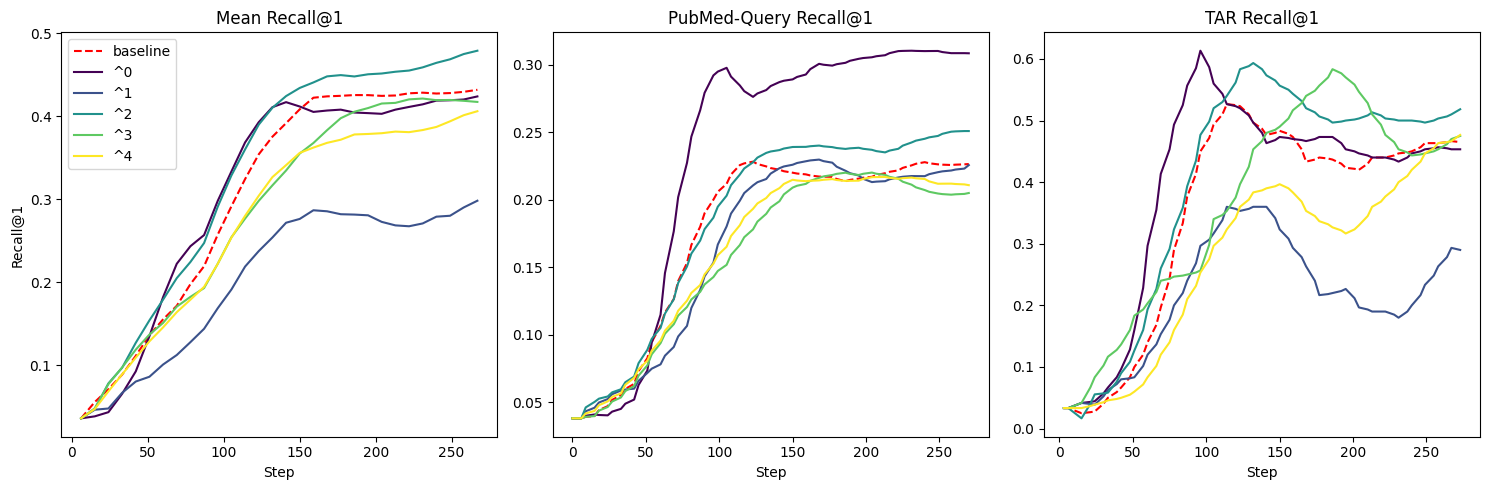

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

runs = api.runs("simon-doehl-ai/Boolean-Ranking")

names = [
    # "clip/bge-small-en-v1.5/b4_lr5E-06_(pubmed-sea)^0no[]",
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-sea)no[]",
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)^0no[]",
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)no[]",
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)^2no[]",
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)^3no[]",
    "clip/biobert-v1.1/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)^4no[]",
    # "clip/bge-small-en-v1.5/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)^0no[]",
    # "clip/bge-small-en-v1.5/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)no[]",
    # "clip/bge-small-en-v1.5/b4_lr8E-06_(pubmed-que_pubmed-sea_raw-jsonl)^2no[]",
]
labels = [
    # "bge-small-en base",
    "baseline",
    "^0",
    "^1",
    "^2",
    "^3",
    "^4",
    # "bge ^0",
    # "bge ^1",
    # "bge ^2",
]
plots = [
    "eval/mean_recall@1",
    "eval/pubmed-query_recall@1",
    "eval/TAR_recall@1",
]
titles = [
    "Mean Recall@1",
    "PubMed-Query Recall@1",
    "TAR Recall@1"
]
colors = []
# colors.append("blue")
colors.append("red")
colors.extend(plt.cm.viridis(np.linspace(0, 1, 5)))
# colors.extend(plt.cm.viridis(np.linspace(0, 1, 5)))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

runs = find_runs(names, runs)
for pl, ax, title in zip(plots, axs, titles):
    for run, label, color in zip(runs, labels, colors):
        hist: pd.DataFrame = run.history()
        data = hist[pl].dropna()
        smoothed = data.rolling(window=10, min_periods=1).mean()
        ax.plot(smoothed.index, smoothed, label=label, color=color,
                linestyle='--' if 'base' in label else '-')

    ax.set_title(title)
    ax.set_xlabel("Step")
    if pl == plots[0]:
        ax.set_ylabel("Recall@1")
        ax.legend()

fig.tight_layout()
fig.savefig("plots/traindatacomp.pdf", format="pdf")
fig.show()